In [1]:
!pip install -q optuna optuna-integration[tfkeras]


[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import random
import os

from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

import tensorflow as tf
from tensorflow.keras import Model, Input, optimizers
from tensorflow.keras.layers import Conv1D, Dense, Dropout, SpatialDropout1D, LayerNormalization, Activation, Add, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from optuna.integration import TFKerasPruningCallback

In [3]:
CSV_PATH   = "ALL_MERGED.csv"   # <--- set your CSV path
DATE_COL   = "Date"
TARGET_COL = "JKSE"
INCLUDE_TARGET_AS_FEATURE = True  # set False to exclude JKSE from X

TEST_SIZE  = 0.20
VAL_SIZE   = 0.10

N_TRIALS   = 50
RANDOM_SEED = 1234

print(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
os.environ["PYTHONHASHSEED"] = str(RANDOM_SEED)

# UQ CONFIG
N_MC  = 100       # number of MC passes
ALPHA = 0.05      # 95% PI
USE_QUANTILES = True  # if False: Gaussian z*std

ROLL_LEN    = 30
HEAT_WIN    = 30
HEAT_STRIDE = 10

1234


In [4]:
df = pd.read_csv(CSV_PATH)
required = [
    "Date","Nickel_Fut","Coal_Fut_Newcastle","Palm_Oil_Fut",
    "USD_IDR","CNY_IDR","EUR_IDR","BTC_USD",
    "FTSE100","HANGSENG","NIKKEI225","SNP500","DOW30","SSE_Composite","JKSE"
]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).set_index(DATE_COL)
df = df.ffill().bfill()
df

,Nickel_Fut,Coal_Fut_Newcastle,Palm_Oil_Fut,USD_IDR,CNY_IDR,EUR_IDR,BTC_USD,FTSE100,HANGSENG,NIKKEI225,SNP500,DOW30,SSE_Composite,JKSE
Date,,,,,,,,,,,,,,
2015-05-01,13750.00,62.20,2136,12962.5,2089.78,14519.9,232.078995,6986.000000,28123.82031,19531.63086,2108.290039,18024.06055,4480.463867,5140.937012
2015-05-02,13750.00,62.20,2136,12962.5,2089.78,14519.9,234.929993,6986.000000,28123.82031,19531.63086,2108.290039,18024.06055,4480.463867,5140.937012
2015-05-03,13750.00,62.20,2136,12962.5,2089.78,14519.9,240.358002,6986.000000,28123.82031,19531.63086,2108.290039,18024.06055,4480.463867,5140.937012
2015-05-04,13750.00,62.20,2136,12980.0,2090.51,14467.5,239.018005,6986.000000,28123.82031,19531.63086,2114.489990,18070.40039,4480.463867,5140.937012
2015-05-05,14245.00,62.50,2136,13047.5,2102.39,14594.9,236.121002,6927.600098,27755.53906,19531.63086,2089.459961,17928.19922,4298.706055,5160.107422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-27,15482.88,93.75,4057,16830.0,2309.37,19127.3,93754.843750,8415.299805,21980.74023,35705.73828,5525.209961,40113.50000,3295.060059,6678.915039
2025-04-28,15637.63,95.60,3943,16855.0,2310.59,19251.8,94978.750000,8417.299805,21971.96094,35839.98828,5528.750000,40227.58984,3288.415039,6722.965820
2025-04-29,15564.00,97.25,3911,16760.0,2305.52,19082.1,94284.789060,8463.500000,22008.10938,35839.98828,5560.830078,40527.62109,3286.655029,6749.075195


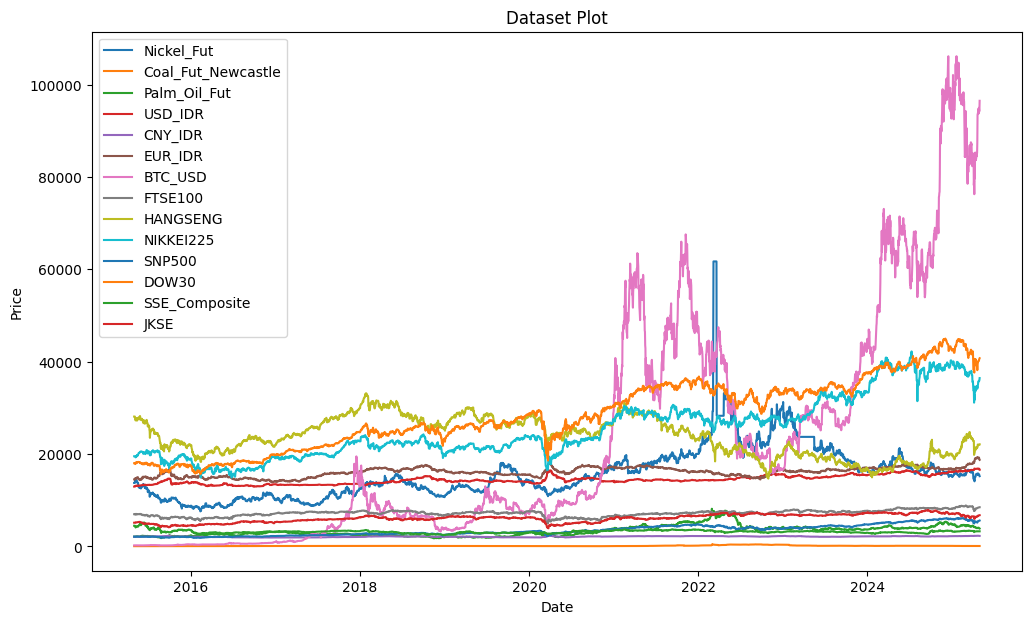

In [5]:
plt.figure(figsize=(12, 7))
plt.plot(df.index, df)
plt.title(f"Dataset Plot")
plt.xlabel("Date"); plt.ylabel("Price")
plt.legend(labels=df.columns)
plt.show()

In [6]:
n = len(df)
test_n = int(np.floor(TEST_SIZE * n))
trainval_n = n - test_n
val_n = int(np.floor(VAL_SIZE * trainval_n))
train_n = trainval_n - val_n

train_df = df.iloc[:train_n].copy()
val_df   = df.iloc[train_n:train_n + val_n].copy()
test_df  = df.iloc[train_n + val_n:].copy()

print(f"Train: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%) | "
      f"Validation: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%) | "
      f"Test: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

Train: 2632 (72.0%) | Validation: 292 (8.0%) | Test: 730 (20.0%)


In [7]:
if INCLUDE_TARGET_AS_FEATURE:
    feature_cols = df.columns.tolist()          # includes TARGET_COL (JKSE)
else:
    feature_cols = [c for c in df.columns if c != TARGET_COL]

In [8]:
# feature_cols = [c for c in df.columns if c != TARGET_COL]
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_scaler.fit(train_df[feature_cols])
y_scaler.fit(train_df[[TARGET_COL]])
y_mean  = float(y_scaler.mean_[0])
y_scale = float(y_scaler.scale_[0])

def scale_block(block):
    X = X_scaler.transform(block[feature_cols])
    y = y_scaler.transform(block[[TARGET_COL]])
    return pd.DataFrame(X, index=block.index, columns=feature_cols), pd.DataFrame(y, index=block.index, columns=[TARGET_COL])

X_train_s, y_train_s = scale_block(train_df)
X_val_s,   y_val_s   = scale_block(val_df)
X_test_s,  y_test_s  = scale_block(test_df)

In [9]:
def make_windows(X_df, y_df, lookback):
    X_vals = X_df.values
    y_vals = y_df.values.squeeze()
    idx = X_df.index

    X_list, y_list, idx_list = [], [], []
    for i in range(lookback, len(X_df)):
        X_list.append(X_vals[i - lookback:i, :])
        y_list.append(y_vals[i])
        idx_list.append(idx[i])

    X_arr = np.array(X_list, dtype=np.float32)
    y_arr = np.array(y_list, dtype=np.float32)
    idx_arr = np.array(idx_list)
    return X_arr, y_arr, idx_arr

In [10]:
def compute_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return [mse, mae, rmse, mape, r2]

In [11]:
def tcn_block(x, filters, kernel_size, dilation_rate, dropout_rate, use_layernorm=True):
    y = Conv1D(filters, kernel_size, padding="causal", dilation_rate=dilation_rate)(x)
    if use_layernorm:
        y = LayerNormalization()(y)
    y = Activation("relu")(y)
    y = SpatialDropout1D(dropout_rate)(y)

    y = Conv1D(filters, kernel_size, padding="causal", dilation_rate=dilation_rate)(y)
    if use_layernorm:
        y = LayerNormalization()(y)
    y = Activation("relu")(y)
    y = SpatialDropout1D(dropout_rate)(y)

    # residual connection (project channels if needed)
    if x.shape[-1] != filters:
        x = Conv1D(filters, 1, padding="same")(x)
    return Add()([x, y])

def build_tcn_model(lookback, n_features, filters, kernel_size, dropout, dilations, num_stacks, lr, use_layernorm=True):
    inp = Input(shape=(lookback, n_features))
    x = inp
    for _ in range(num_stacks):
        for d in dilations:
            x = tcn_block(x, filters, kernel_size, d, dropout, use_layernorm)

    # compress and take last step
    x = Conv1D(1, 1, padding="same")(x)
    x = Lambda(lambda t: t[:, -1, :])(x)  # (batch, 1)
    out = Dense(1)(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss="mse")
    return model

In [12]:
def objective(trial):
    lookback   = trial.suggest_categorical("lookback", [30, 45, 60, 90])
    filters    = trial.suggest_int("filters", 32, 128, step=32)
    kernel_sz  = trial.suggest_categorical("kernel_size", [3, 5, 7])
    dropout    = trial.suggest_float("dropout", 0.0, 0.5)
    num_stacks = trial.suggest_int("num_stacks", 1, 2)
    dilation_set = trial.suggest_categorical("dilations", [
        (1, 2, 4),
        (1, 2, 4, 8)
    ])
    lr         = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    epochs     = trial.suggest_int("epochs", 30, 100, step=10)
    patience   = trial.suggest_int("patience", 5, 10)

    X_tr, y_tr, _ = make_windows(X_train_s, y_train_s, lookback)
    X_va, y_va, _ = make_windows(X_val_s,   y_val_s,   lookback)

    model = build_tcn_model(
        lookback=lookback,
        n_features=len(feature_cols),
        filters=filters,
        kernel_size=kernel_sz,
        dropout=dropout,
        dilations=list(dilation_set),
        num_stacks=num_stacks,
        lr=lr,
        use_layernorm=True
    )

    callbacks = [
        EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True),
        TFKerasPruningCallback(trial, monitor="val_loss"),
    ]

    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_va, y_va),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=callbacks
    )
    return min(history.history["val_loss"])

In [13]:
sampler = optuna.samplers.TPESampler(seed=RANDOM_SEED)
pruner  = optuna.pruners.MedianPruner(n_startup_trials=15, n_warmup_steps=10)
study = optuna.create_study(direction="minimize", sampler=sampler, pruner=pruner)

print("\nStarting Optuna study...")
start_opt = time.time()
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)
end_opt = time.time()
print(f"Optuna finished in {end_opt - start_opt:.4f} seconds")
print("Best trial:", study.best_trial.number)
print("Best val_loss:", study.best_value)
print("Best params:", study.best_params)

best = study.best_params
BEST_LOOKBACK = best["lookback"]

[I 2025-11-29 17:54:14,157] A new study created in memory with name: no-name-f1877360-fa51-42dd-9848-1b3029d1c3e5



Starting Optuna study...


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\Alden\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2, 4) which is of type tuple.
  warnings.warn(message)
C:\Users\Alden\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2, 4, 8) which is of type tuple.
  warnings.warn(message)



[I 2025-11-29 17:56:10,492] Trial 0 finished with value: 0.029058828949928284 and parameters: {'lookback': 90, 'filters': 128, 'kernel_size': 7, 'dropout': 0.4790696768418526, 'num_stacks': 2, 'dilations': (1, 2, 4, 8), 'lr': 0.0014493825421745437, 'batch_size': 32, 'epochs': 70, 'patience': 5}. Best is trial 0 with value: 0.029058828949928284.
[I 2025-11-29 17:58:20,843] Trial 1 finished with value: 0.004284467548131943 and parameters: {'lookback': 45, 'filters': 32, 'kernel_size': 5, 'dropout': 0.1986012888630771, 'num_stacks': 2, 'dilations': (1, 2, 4, 8), 'lr': 0.002996548869421276, 'batch_size': 64, 'epochs': 80, 'patience': 9}. Best is trial 1 with value: 0.004284467548131943.
[I 2025-11-29 17:58:46,638] Trial 2 finished with value: 0.431835412979126 and parameters: {'lookback': 45, 'filters': 32, 'kernel_size': 7, 'dropout': 0.2973123899672244, 'num_stacks': 2, 'dilations': (1, 2, 4, 8), 'lr': 0.00036315899074972665, 'batch_size': 128, 'epochs': 70, 'patience': 5}. Best is tria

In [14]:
X_train_w, y_train_w, idx_train = make_windows(X_train_s, y_train_s, BEST_LOOKBACK)
X_val_w,   y_val_w,   idx_val   = make_windows(X_val_s,   y_val_s,   BEST_LOOKBACK)
X_test_w,  y_test_w,  idx_test  = make_windows(X_test_s,  y_test_s,  BEST_LOOKBACK)

In [15]:
final_model = build_tcn_model(
    lookback=BEST_LOOKBACK,
    n_features=len(feature_cols),
    filters=best["filters"],
    kernel_size=best["kernel_size"],
    dropout=best["dropout"],
    dilations=list(best["dilations"]),
    num_stacks=best["num_stacks"],
    lr=best["lr"],
    use_layernorm=True
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=best["patience"], restore_best_weights=True),
    ModelCheckpoint("Model Checkpoints/tcn_optuna_best.keras", monitor="val_loss", save_best_only=True)
]

print("\nRetraining final TCN on TRAIN (validate on VAL)...")
start_train = time.time()
history = final_model.fit(
    X_train_w, y_train_w,
    validation_data=(X_val_w, y_val_w),
    epochs=best["epochs"],
    batch_size=best["batch_size"],
    verbose=1,
    callbacks=callbacks
)
end_train = time.time()
print(f"Final training time: {end_train - start_train:.4f} seconds")


Retraining final TCN on TRAIN (validate on VAL)...
Epoch 1/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 116ms/step - loss: 11.3641 - val_loss: 0.0500
Epoch 2/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - loss: 0.2507 - val_loss: 0.0570
Epoch 3/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - loss: 0.1053 - val_loss: 0.1189
Epoch 4/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 0.0530 - val_loss: 0.0112
Epoch 5/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 0.0303 - val_loss: 0.0094
Epoch 6/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - loss: 0.0197 - val_loss: 0.0075
Epoch 7/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - loss: 0.0144 - val_loss: 0.0054
Epoch 8/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - loss: 0.0118 - val_loss: 0.0034
Epoch 9/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - loss: 0.0094 - val_loss: 0.0044
Epoch 10/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - loss: 0.0079 - val_loss: 0.0052
Epoch 11/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - loss: 0.0071 - val_loss: 0.006

In [16]:
def predict_series(model, X_block, idx_block):
    yhat_s = model.predict(X_block, verbose=0)
    yhat = y_scaler.inverse_transform(yhat_s).squeeze()
    return pd.Series(yhat, index=idx_block, name="Pred")

pred_train = predict_series(final_model, X_train_w, idx_train)
pred_val   = predict_series(final_model, X_val_w,   idx_val)

start_test = time.time()
pred_test  = predict_series(final_model, X_test_w,  idx_test)
end_test = time.time()
print(f"Testing (inference) time: {end_test - start_test:.4f} seconds")

Testing (inference) time: 0.8731 seconds


In [17]:
actual       = df[TARGET_COL]
actual_train = actual.loc[idx_train]
actual_val   = actual.loc[idx_val]
actual_test  = actual.loc[idx_test]

In [18]:
metrics_train = compute_metrics(actual_train.values, pred_train.values)
metrics_val   = compute_metrics(actual_val.values,   pred_val.values)
metrics_test  = compute_metrics(actual_test.values,  pred_test.values)

metrics_df = pd.DataFrame(
    [metrics_train, metrics_val, metrics_test],
    columns=["MSE", "MAE", "RMSE", "MAPE", "R²"],
    index=["Train", "Validation", "Test"]
)

pd.set_option("display.float_format", "{:.4f}".format)
print("\n=== Metrics Summary (TCN — Optuna best) ===")
print(metrics_df.round(4))


=== Metrics Summary (TCN — Optuna best) ===
                 MSE     MAE    RMSE   MAPE     R²
Train      2173.2559 31.4825 46.6182 0.0056 0.9957
Validation 1706.5445 31.1297 41.3103 0.0045 0.9205
Test       3550.7193 41.3863 59.5879 0.0059 0.9677


In [19]:
# === NEW: base_metrics (dict) & UQ metrics ===
def base_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return dict(MSE=mse, MAE=mae, RMSE=rmse, MAPE=mape, R2=r2)

def uq_metrics(y_true, L, U, alpha=ALPHA):
    y = np.asarray(y_true); L = np.asarray(L); U = np.asarray(U)
    cover = (y >= L) & (y <= U)
    picp = cover.mean()
    mpiw = np.mean(U - L)

    penalty = np.where(y < L, (2/alpha)*(L - y),
              np.where(y > U, (2/alpha)*(y - U), 0.0))

    winkler = np.mean((U - L) + penalty)
    return dict(PICP=picp, MPIW=mpiw, Winkler=winkler)


In [20]:
# === NEW: Monte-Carlo Dropout on final_model ===
@tf.function
def mc_call(m, X, training=True):
    # forces dropout layers (SpatialDropout1D) to stay active
    return m(X, training=training)

def predict_mc(m, X_np, idx, n_mc=N_MC, use_quantiles=USE_QUANTILES, alpha=ALPHA):
    Ys_scaled = []
    X_tf = tf.convert_to_tensor(X_np, dtype=tf.float32)
    for _ in range(n_mc):
        y_s = mc_call(m, X_tf, training=True).numpy().squeeze()  # (N,)
        Ys_scaled.append(y_s)

    Ys_scaled = np.stack(Ys_scaled, axis=1)   # (N, T)
    Ys = Ys_scaled * y_scale + y_mean        # inverse scale whole ensemble

    mean = Ys.mean(axis=1)
    std  = Ys.std(axis=1, ddof=1)

    if use_quantiles:
        lower = np.quantile(Ys, q=alpha/2,     axis=1)
        upper = np.quantile(Ys, q=1-alpha/2.0, axis=1)
    else:
        from scipy.stats import norm
        z = norm.ppf(1 - alpha/2.0)
        lower, upper = mean - z * std, mean + z * std

    return (
        pd.Series(mean,  index=idx, name="mean"),
        pd.Series(lower, index=idx, name=f"lower_{int((1-alpha)*100)}"),
        pd.Series(upper, index=idx, name=f"upper_{int((1-alpha)*100)}"),
        pd.Series(std,   index=idx, name="mc_std"),
        Ys  # all MC samples in real scale, shape (N, T)
    )

print("\nRunning MC Dropout on Optuna-tuned TCN...")
start_opt_mc = time.time()
mean_train, L_train, U_train, std_train, Ys_train = predict_mc(final_model, X_train_w, idx_train)
mean_val,   L_val,   U_val,   std_val,   Ys_val   = predict_mc(final_model, X_val_w,   idx_val)
mean_test,  L_test,  U_test,  std_test,  Ys_test  = predict_mc(final_model, X_test_w,  idx_test)
end_opt_mc = time.time()
print(f"[MC] Done in {end_opt_mc - start_opt_mc:.4f}s")


Running MC Dropout on Optuna-tuned TCN...
[MC] Done in 287.4700s


In [21]:
print(f"\n=== UQ Metrics ({int((1-ALPHA)*100)}% PI) — MC on Optuna TCN ===")
print("Train:", uq_metrics(actual_train.values, L_train.values, U_train.values, ALPHA))
print("Val:  ", uq_metrics(actual_val.values,   L_val.values,   U_val.values,   ALPHA))
print("Test: ", uq_metrics(actual_test.values,  L_test.values,  U_test.values,  ALPHA))

# Summary table using MC mean as point forecast
rows = []
for tag, y_true_s, y_pred_s, L_s, U_s in [
    ("Train", actual_train, mean_train, L_train, U_train),
    ("Val",   actual_val,   mean_val,   L_val,   U_val),
    ("Test",  actual_test,  mean_test,  L_test,  U_test),
]:
    b = base_metrics(y_true_s.values, y_pred_s.values)
    u = uq_metrics(y_true_s.values, L_s.values, U_s.values, ALPHA)
    rows.append({
        "Split": tag,
        **{k: round(v,4) for k,v in b.items()},
        "PICP": round(u["PICP"],4),
        "MPIW": round(u["MPIW"],4),
        "Winkler": round(u["Winkler"],4)
    })

summary_mc_df = pd.DataFrame(rows)
print("\n=== Summary (Point = MC mean + UQ) — TCN (Optuna) + MC Dropout ===")
print(summary_mc_df.to_string(index=False))


=== UQ Metrics (95% PI) — MC on Optuna TCN ===
Train: {'PICP': 0.9393468118195957, 'MPIW': 189.97014251519133, 'Winkler': 285.0972953742565}
Val:   {'PICP': 0.9741379310344828, 'MPIW': 214.560004346124, 'Winkler': 243.24099248863465}
Test:  {'PICP': 0.9462686567164179, 'MPIW': 216.0062823941814, 'Winkler': 343.28709745738115}

=== Summary (Point = MC mean + UQ) — TCN (Optuna) + MC Dropout ===
Split       MSE     MAE    RMSE   MAPE     R2   PICP     MPIW  Winkler
Train 2211.8716 31.5155 47.0305 0.0056 0.9956 0.9393 189.9701 285.0973
  Val 1922.0498 33.7901 43.8412 0.0049 0.9105 0.9741 214.5600 243.2410
 Test 3472.8462 39.2291 58.9309 0.0056 0.9684 0.9463 216.0063 343.2871


In [22]:
# === NEW: approximate epistemic vs aleatoric on test ===
resid_val = actual_val.values - mean_val.values
sigma2_aleatoric = np.var(resid_val, ddof=1)

var_total_test = np.var(Ys_test, axis=1, ddof=1)
var_epistemic  = np.maximum(0.0, var_total_test - sigma2_aleatoric)
var_aleatoric  = np.full_like(var_total_test, sigma2_aleatoric)

epi_series = pd.Series(var_epistemic, index=idx_test, name="var_epistemic")
ale_series = pd.Series(var_aleatoric, index=idx_test, name="var_aleatoric")
tot_series = pd.Series(var_total_test, index=idx_test, name="var_total")

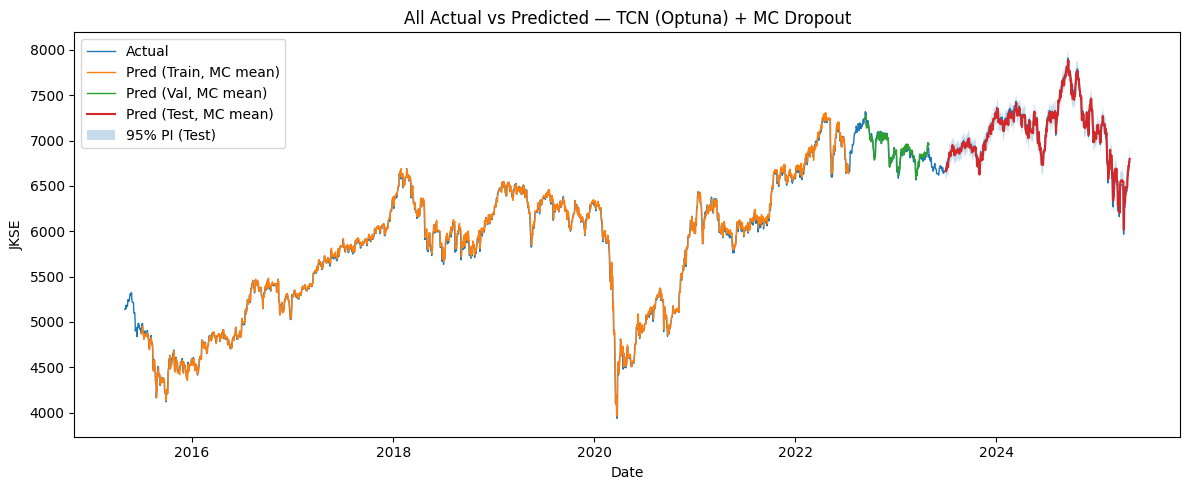

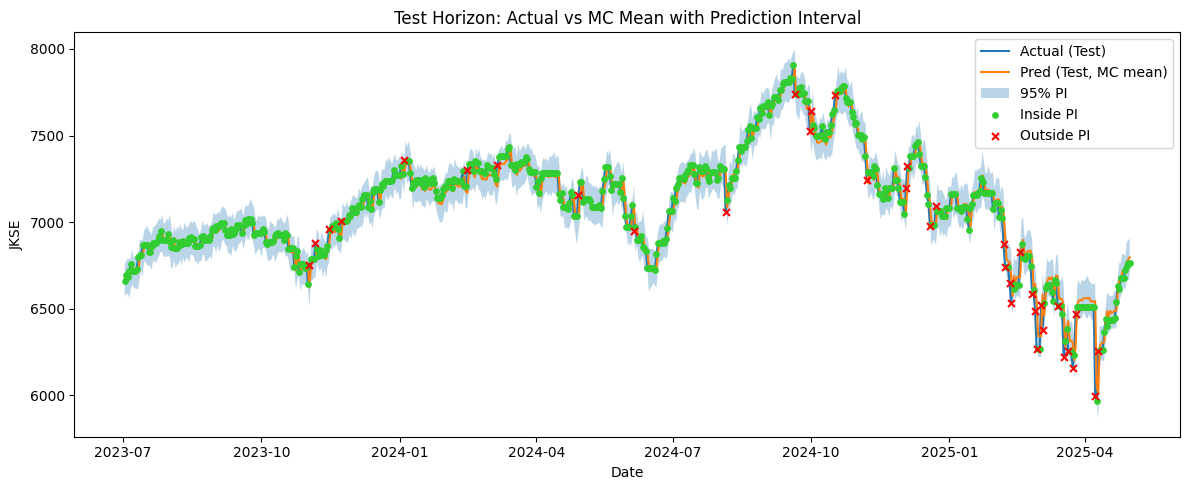

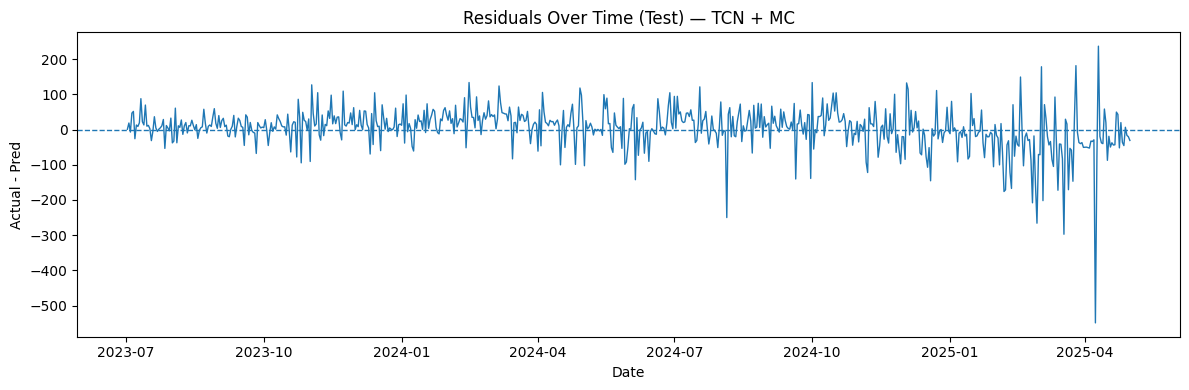

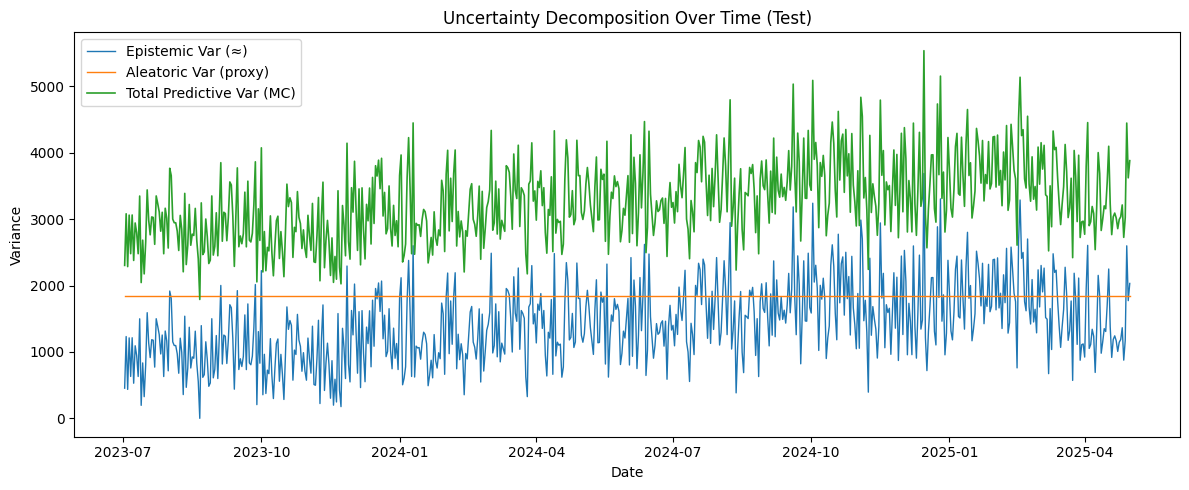

In [23]:
# === NEW: full-series + test-horizon plots with MC PI ===
def classify_inside_outside(y_true_s, L_s, U_s):
    y = np.asarray(y_true_s); L = np.asarray(L_s); U = np.asarray(U_s)
    inside = (y >= L) & (y <= U)
    return inside, ~inside

# 1) Full series view
plt.figure(figsize=(12,5))
plt.plot(actual.index, actual.values, label="Actual", linewidth=1)
plt.plot(mean_train.index, mean_train.values, label="Pred (Train, MC mean)", linewidth=1)
plt.plot(mean_val.index,   mean_val.values,   label="Pred (Val, MC mean)", linewidth=1)
plt.plot(mean_test.index,  mean_test.values,  label="Pred (Test, MC mean)", linewidth=1.5)
plt.fill_between(L_test.index, L_test.values, U_test.values, alpha=0.25,
                 label=f"{int((1-ALPHA)*100)}% PI (Test)")
plt.title("All Actual vs Predicted — TCN (Optuna) + MC Dropout")
plt.xlabel("Date"); plt.ylabel(TARGET_COL); plt.legend(); plt.tight_layout(); plt.show()

# 2) Test horizon with inside/outside markers
inside_mask, outside_mask = classify_inside_outside(actual_test.values, L_test.values, U_test.values)
plt.figure(figsize=(12,5))
plt.plot(actual_test.index, actual_test.values, label="Actual (Test)", linewidth=1.5)
plt.plot(mean_test.index,   mean_test.values,   label="Pred (Test, MC mean)", linewidth=1.5)
plt.fill_between(L_test.index, L_test.values, U_test.values, alpha=0.30,
                 label=f"{int((1-ALPHA)*100)}% PI")
plt.scatter(actual_test.index[inside_mask],  actual_test.values[inside_mask],
            s=15, label="Inside PI", zorder=3, color="limegreen")
plt.scatter(actual_test.index[outside_mask], actual_test.values[outside_mask],
            s=25, marker="x", label="Outside PI", zorder=3, color="red")
plt.title("Test Horizon: Actual vs MC Mean with Prediction Interval")
plt.xlabel("Date"); plt.ylabel(TARGET_COL); plt.legend(); plt.tight_layout(); plt.show()

# 3) Residuals (test)
residuals_test = pd.Series(actual_test.values - mean_test.values, index=actual_test.index, name="Residuals")
plt.figure(figsize=(12,4))
plt.plot(residuals_test.index, residuals_test.values, linewidth=1)
plt.axhline(0, ls="--", lw=1); plt.title("Residuals Over Time (Test) — TCN + MC")
plt.xlabel("Date"); plt.ylabel("Actual - Pred"); plt.tight_layout(); plt.show()

# 4) Uncertainty decomposition
plt.figure(figsize=(12,5))
plt.plot(epi_series.index, epi_series.values, label="Epistemic Var (≈)", linewidth=1)
plt.plot(ale_series.index, ale_series.values, label="Aleatoric Var (proxy)", linewidth=1)
plt.plot(tot_series.index, tot_series.values, label="Total Predictive Var (MC)", linewidth=1.2)
plt.title("Uncertainty Decomposition Over Time (Test)")
plt.xlabel("Date"); plt.ylabel("Variance"); plt.legend(); plt.tight_layout(); plt.show()

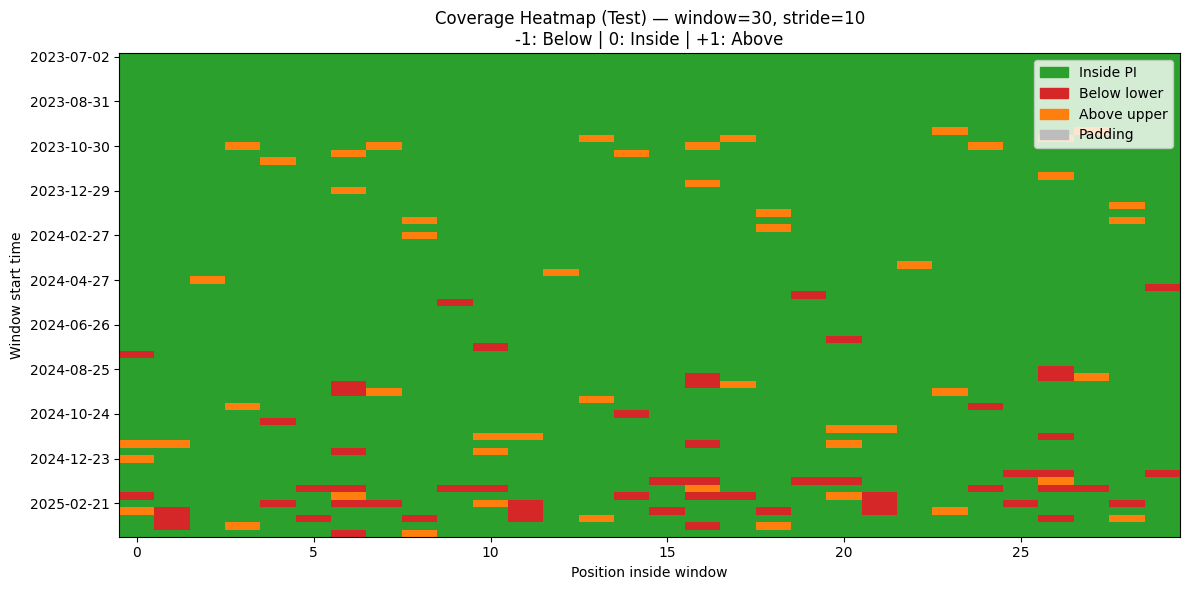

In [24]:
# ---------------------- (a) Coverage heatmap (per-window) ----------------------
from matplotlib.colors import ListedColormap, BoundaryNorm
y_true = actual_test.values; L_arr = L_test.values; U_arr = U_test.values
below_mask = (y_true < L_arr); above_mask = (y_true > U_arr); inside_mask = (y_true >= L_arr) & (y_true <= U_arr)
status = np.zeros_like(y_true, dtype=int); status[below_mask] = -1; status[above_mask] = 1
starts = np.arange(0, len(status)-HEAT_WIN+1, HEAT_STRIDE)
if len(starts) == 0: starts = np.array([0]); HEAT_WIN = len(status)
mat = []; x_tick_labels = []
for s in starts:
    e = min(s + HEAT_WIN, len(status)); row = status[s:e]
    if e - s < HEAT_WIN: row = np.pad(row, (0, HEAT_WIN - (e - s)), constant_values=np.nan)
    mat.append(row); x_tick_labels.append(actual_test.index[s].strftime('%Y-%m-%d'))
mat = np.vstack(mat)
cmap = ListedColormap(["#d62728", "#2ca02c", "#ff7f0e", "#bdbdbd"])  # red, green, orange, grey
bounds = [-1.5, -0.5, 0.5, 1.5, 2.5]; norm = BoundaryNorm(bounds, cmap.N)
plt.figure(figsize=(12,6))
plt.imshow(mat, aspect="auto", interpolation="nearest", cmap=cmap, norm=norm)
plt.title(f"Coverage Heatmap (Test) — window={HEAT_WIN}, stride={HEAT_STRIDE}\n-1: Below | 0: Inside | +1: Above")
plt.xlabel("Position inside window"); plt.ylabel("Window start time")
yticks = np.arange(0, len(starts), max(1, len(starts)//10))
plt.yticks(yticks, [x_tick_labels[i] for i in yticks])
import matplotlib.patches as mpatches
legend_patches = [
    mpatches.Patch(color="#2ca02c", label="Inside PI"),
    mpatches.Patch(color="#d62728", label="Below lower"),
    mpatches.Patch(color="#ff7f0e", label="Above upper"),
    mpatches.Patch(color="#bdbdbd", label="Padding")
]
plt.legend(handles=legend_patches, loc="upper right", frameon=True)
plt.tight_layout(); plt.show()

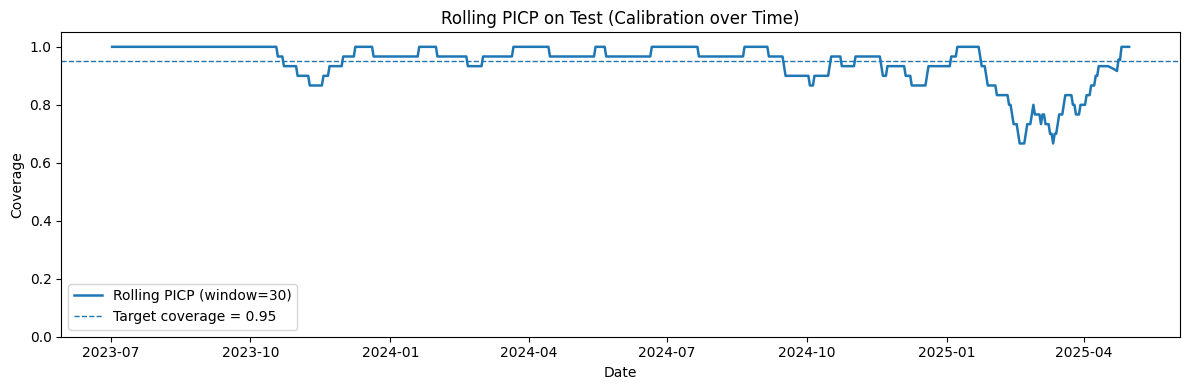

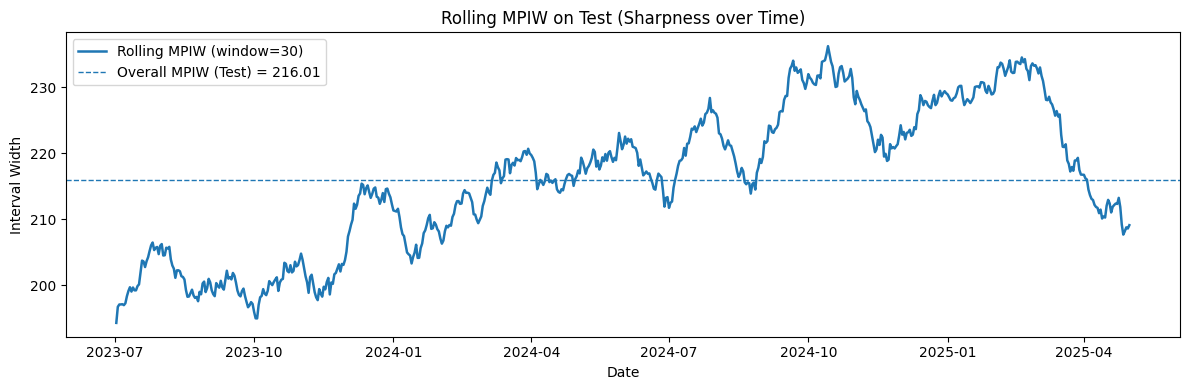

In [25]:
# ---------------------- (b) Rolling PICP & (c) Rolling MPIW ----------------------
inside_series = pd.Series(((y_true >= L_arr) & (y_true <= U_arr)).astype(int), index=actual_test.index, name="inside")
rolling_picp = inside_series.rolling(window=ROLL_LEN, center=True, min_periods=max(3, ROLL_LEN//3)).mean()
plt.figure(figsize=(12,4))
plt.plot(rolling_picp.index, rolling_picp.values, linewidth=1.8, label=f"Rolling PICP (window={ROLL_LEN})")
plt.axhline(1 - ALPHA, ls="--", lw=1, label=f"Target coverage = {1-ALPHA:.2f}")
plt.ylim(0, 1.05); plt.title("Rolling PICP on Test (Calibration over Time)")
plt.xlabel("Date"); plt.ylabel("Coverage"); plt.legend(); plt.tight_layout(); plt.show()

width_series   = pd.Series((U_arr - L_arr), index=actual_test.index, name="PI_width")
rolling_mpiw   = width_series.rolling(window=ROLL_LEN, center=True, min_periods=max(3, ROLL_LEN//3)).mean()
overall_mpiw_t = width_series.mean()
plt.figure(figsize=(12,4))
plt.plot(rolling_mpiw.index, rolling_mpiw.values, linewidth=1.8, label=f"Rolling MPIW (window={ROLL_LEN})")
plt.axhline(overall_mpiw_t, ls="--", lw=1, label=f"Overall MPIW (Test) = {overall_mpiw_t:.2f}")
plt.title("Rolling MPIW on Test (Sharpness over Time)")
plt.xlabel("Date"); plt.ylabel("Interval Width"); plt.legend(); plt.tight_layout(); plt.show()

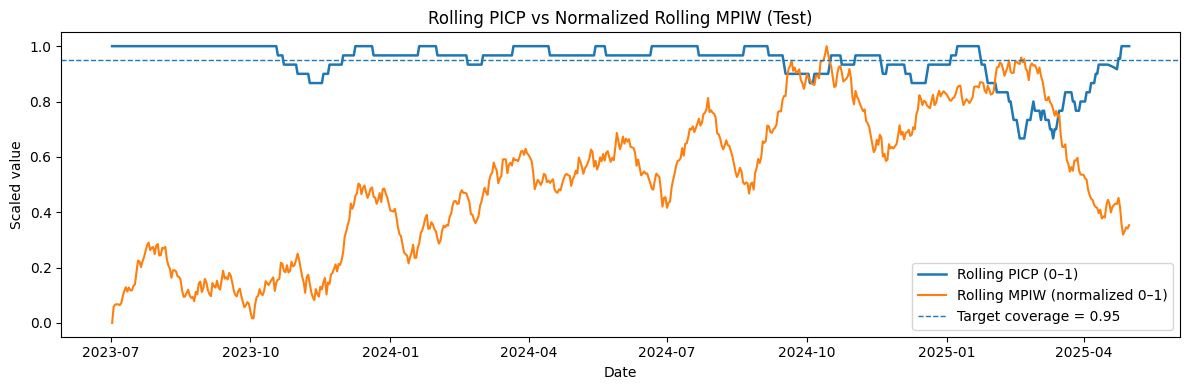

In [26]:
# (Optional) If you want a normalized comparison with Rolling PICP in a separate plot:
norm_mpiw = (rolling_mpiw - np.nanmin(rolling_mpiw)) / (np.nanmax(rolling_mpiw) - np.nanmin(rolling_mpiw) + 1e-12)
plt.figure(figsize=(12, 4))
plt.plot(rolling_picp.index, rolling_picp.values, linewidth=1.8, label="Rolling PICP (0–1)")
plt.plot(norm_mpiw.index, norm_mpiw.values, linewidth=1.5, label="Rolling MPIW (normalized 0–1)")
plt.axhline(1 - ALPHA, ls="--", lw=1, label=f"Target coverage = {1-ALPHA:.2f}")
plt.title("Rolling PICP vs Normalized Rolling MPIW (Test)")
plt.xlabel("Date"); plt.ylabel("Scaled value")
plt.legend(); plt.tight_layout(); plt.show()

In [27]:
# ---------------------- Compact summary table ----------------------
def table_metrics():
    rows = []
    for tag, y_true_s, y_pred_s, L_s, U_s in [
        ("Train", actual_train, mean_train, L_train, U_train),
        ("Val",   actual_val,   mean_val,   L_val,   U_val),
        ("Test",  actual_test,  mean_test,  L_test,  U_test),
    ]:
        b = base_metrics(y_true_s.values, y_pred_s.values)
        u = uq_metrics(y_true_s.values, L_s.values, U_s.values, ALPHA)
        rows.append({"Split": tag, **{k: round(v,4) for k,v in b.items()}, "PICP": round(u["PICP"],4),
                     "MPIW": round(u["MPIW"],4), "Winkler": round(u["Winkler"],4)})
    return pd.DataFrame(rows)

summary_df = table_metrics()
print("\n=== Summary (Point + UQ) — TCN + MC Dropout ===")
print(summary_df.to_string(index=False))


=== Summary (Point + UQ) — TCN + MC Dropout ===
Split       MSE     MAE    RMSE   MAPE     R2   PICP     MPIW  Winkler
Train 2211.8716 31.5155 47.0305 0.0056 0.9956 0.9393 189.9701 285.0973
  Val 1922.0498 33.7901 43.8412 0.0049 0.9105 0.9741 214.5600 243.2410
 Test 3472.8462 39.2291 58.9309 0.0056 0.9684 0.9463 216.0063 343.2871


In [28]:
# === CONFIGURATION ===
results_dir = os.path.join("..", "Results")
predicted_path = os.path.join(results_dir, "ALL_UQ_PREDICTED.csv")
metrics_path = os.path.join(results_dir, "ALL_UQ_METRICS.csv")

# Manual model name (since __file__ isn't available in notebooks)
model = "tcn_mcd"
model_name = f"{model}_{RANDOM_SEED}"   # change this for each notebook (e.g., GRU_Baseline)
print("Model Name for Documentation:", model_name)

# Create Results directory if not exists
os.makedirs(results_dir, exist_ok=True)

# ==========================================
# 1️⃣ PREPARE AND ALIGN TESTING DATAFRAME
# ==========================================

# Convert dates
test_dates = test_df.index.to_series().reset_index(drop=True)
actual_values = test_df[TARGET_COL].values

# If ALL_PREDICTED doesn't exist, create the base file
if not os.path.exists(predicted_path):
    print("Creating ALL_PREDICTED.csv ...")
    base_df = pd.DataFrame({
        "date": test_dates,
        "actual": actual_values
    })
    base_df.to_csv(predicted_path, index=False)

# Load and ensure datetime consistency
all_pred_df = pd.read_csv(predicted_path)
all_pred_df["date"] = pd.to_datetime(all_pred_df["date"])

# Ensure the file covers full test range (in case it was made from smaller data)
base_df = pd.DataFrame({
    "date": test_dates,
    "actual": actual_values
})
# Outer merge to make sure we have the full timeline
all_pred_df = pd.merge(base_df, all_pred_df, on=["date", "actual"], how="outer")

# Create new prediction column (aligned to date)
pred_series = pd.Series(mean_test.values, index=pd.to_datetime(idx_test), name=model_name)
pred_series = pred_series.reindex(all_pred_df["date"])  # align by date

# Create lower and upper bound series (aligned to date)
L_series = pd.Series(L_test.values, index=pd.to_datetime(idx_test), name=f"{model_name}_L")
U_series = pd.Series(U_test.values, index=pd.to_datetime(idx_test), name=f"{model_name}_U")
L_series = L_series.reindex(all_pred_df["date"])  # align by date
U_series = U_series.reindex(all_pred_df["date"])  # align by date

# Add or update the model column
all_pred_df[model_name] = pred_series.values
all_pred_df[f"{model_name}_L"] = L_series.values  # Add lower bound
all_pred_df[f"{model_name}_U"] = U_series.values  # Add upper bound

# Sort and save
all_pred_df = all_pred_df.sort_values("date").reset_index(drop=True)
all_pred_df.to_csv(predicted_path, index=False)
print(f"✅ Predictions saved to {predicted_path}")

# ==========================================
# 2️⃣ RECORD METRICS SUMMARY
# ==========================================
metrics_columns = [
    "timestamp",
    "model_name", 
    "seed",
    "mse",
    "mae",
    "rmse", 
    "mape",
    "r2_score",
    "picp",
    "mpiw",
    "winkler_score",
    "training_time_s",
    "testing_time_s", 
    "hpo_trial_s",
    "hpo_time_s"
]

# Create ALL_METRICS if missing
if not os.path.exists(metrics_path):
    print("Creating ALL_METRICS.csv ...")
    pd.DataFrame(columns=metrics_columns).to_csv(metrics_path, index=False)

# Current timestamp
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Extract metrics
mse, mae, rmse, mape, r2 = base_metrics(actual_test.values, mean_test.values).values()
picp, mpiw, winkler = uq_metrics(actual_test.values, L_test.values, U_test.values, ALPHA).values()

# Build metrics row
metrics_row = {
    "timestamp": timestamp,
    "model_name": model_name,
    "seed": RANDOM_SEED,
    "mse": mse,
    "mae": mae,
    "rmse": rmse,
    "mape": mape,
    "r2_score": r2,
    "picp": picp,
    "mpiw": mpiw,
    "winkler_score": winkler,
    "training_time_s": round(end_train - start_train, 4),
    "testing_time_s": round(end_opt_mc - start_opt_mc, 4),
    "hpo_trial_s": N_TRIALS,
    "hpo_time_s": round(end_opt - start_opt, 4),
}

# Append metrics
all_metrics_df = pd.read_csv(metrics_path)
all_metrics_df = pd.concat([all_metrics_df, pd.DataFrame([metrics_row])], ignore_index=True)
all_metrics_df.to_csv(metrics_path, index=False)
print(f"✅ Metrics appended to {metrics_path}")

print("\n📄 Documentation of predictions and metrics completed successfully.")


Model Name for Documentation: tcn_mcd_1234
✅ Predictions saved to ..\Results\ALL_UQ_PREDICTED.csv
✅ Metrics appended to ..\Results\ALL_UQ_METRICS.csv

📄 Documentation of predictions and metrics completed successfully.
